In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
import matplotlib.pyplot as plt

In [54]:
weather_data = pd.read_csv("api_weather_data_toronto.csv", index_col=[0])

# set up target y
weather_data["target_2m_temp"] = weather_data["temperature_2m"].shift(-1)
weather_data = weather_data.dropna(subset=["target_2m_temp"])  # Drop rows where target is NaN
print(f"Dataset shape: {weather_data.shape}")


Dataset shape: (17543, 17)


In [55]:
# split data
x=weather_data[['temperature_2m', 'dew_point_2m',
       'precipitation', 'weather_code', 'wind_speed_120m',
       'wind_direction_80m', 'visibility', 'relative_humidity_2m', 'month_cos',
       'DayOfWeek', 'hour', 'day_cos']]
y=weather_data["target_2m_temp"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=False
)

In [56]:
# normalize
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [57]:
# basic feedforward architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    BatchNormalization(),           # Normalize activations to speed up training and stabilize learning
    Dropout(0.3),                  # Randomly drop 30% of neurons during training to reduce overfitting

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),

    Dense(1)  # Output layer for regression
])

/home/python/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
# Train
history = model.fit(
    x_train, y_train, 
    epochs=200,  # More epochs, but early stopping will control
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7081 - mae: 0.9971 - val_loss: 1.3217 - val_mae: 0.8185
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6483 - mae: 0.9668 - val_loss: 1.5986 - val_mae: 0.9947
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5738 - mae: 0.9554 - val_loss: 5.0933 - val_mae: 1.0559
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7430 - mae: 0.9889 - val_loss: 3.0199 - val_mae: 1.0236
Epoch 5/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6720 - mae: 0.9750 - val_loss: 3.0062 - val_mae: 1.3977
Epoch 6/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5858 - mae: 0.9572 - val_loss: 1.6452 - val_mae: 0.8086
Epoch 7/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6557 - mae: 0.9786 - val_loss: 3.4987 - val_mae: 1.3642
Epoch 8/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6448 - mae: 0.9636 - val_loss: 4.8919 - val_mae: 1.4135
Epoch 9/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss:

In [66]:
loss, mae = model.evaluate(x_test, y_test)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5739 - mae: 0.5863


In [67]:
model.save("models/basic.keras")

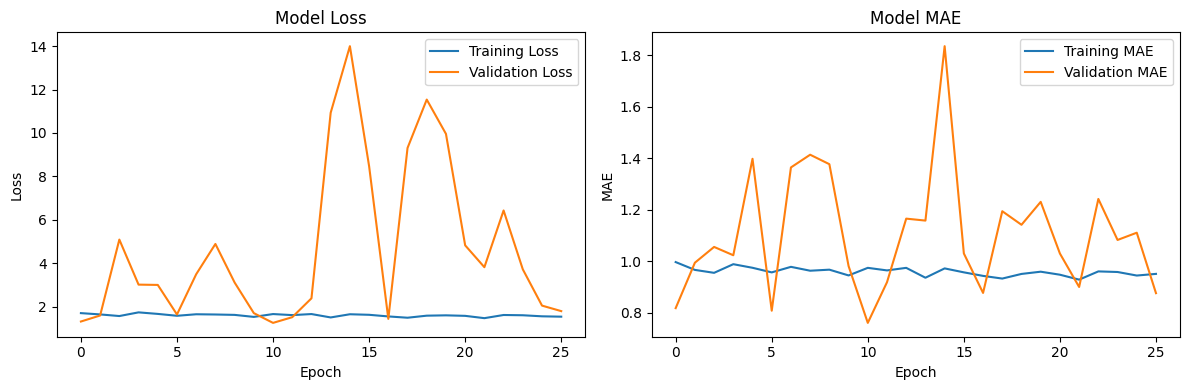

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


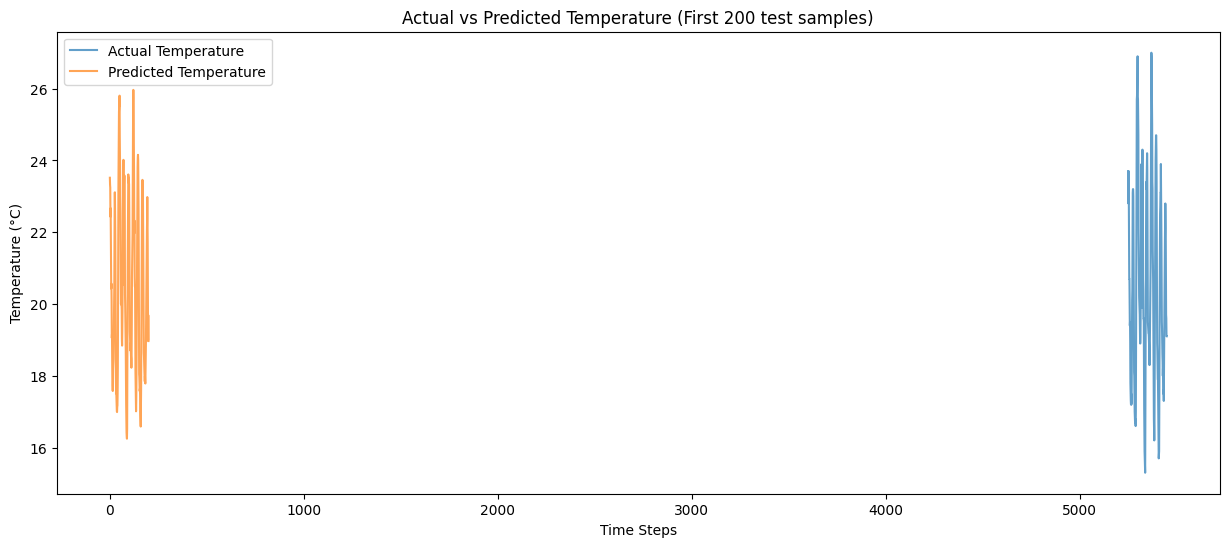

In [68]:
# Cell 9: Plot training history (NEW)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Cell 10: Make predictions and visualize (NEW)
predictions = model.predict(x_test)

# Plot actual vs predicted for a subset
plt.figure(figsize=(15, 6))
n_samples = 200  # Show first 200 test predictions
plt.plot(y_test[:n_samples], label='Actual Temperature', alpha=0.7)
plt.plot(predictions[:n_samples], label='Predicted Temperature', alpha=0.7)
plt.title('Actual vs Predicted Temperature (First 200 test samples)')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()